# Code to evaluate continuity budgets in NeverWorld2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import intake
import xgcm

The continuity equation for an adiabatic layer is
\begin{align} 
\partial_t h + \nabla\cdot \left( h \mathbf{u} \right )  = 0 \;,
\end{align}

Following Young's thickness weighted average formulation (2012), the coarse-grained continuity equation is

\begin{align} 
\partial_t \overline{h} + \nabla\cdot \left( \overline{ h \mathbf{u} } \right )  = 0 \;,
\end{align}

where the overline represents the coarse-graining operator.
We do not break the continuity equation into mean and eddy terms.




## Load OSN Data from Catalog

First we look at the available data.
The data catalog lives at https://github.com/ocean-eddy-cpt/cpt-data/blob/master/catalog.yaml.
For now, this repo is still private, so we have to download the catalog file.
In the future, when we make it public, we will be able to load the catalog directly a github url.

In [2]:
cat = intake.open_catalog('../cpt-data/catalog.yaml')
list(cat)

['neverworld_five_day_averages',
 'neverworld_quarter_degree_snapshots',
 'neverworld_quarter_degree_averages',
 'neverworld_quarter_degree_static',
 'neverworld_quarter_degree_stats',
 'neverworld_eighth_degree_averages',
 'neverworld_eighth_degree_static',
 'neverworld_eighth_degree_stats',
 'neverworld_sixteenth_degree_snapshots',
 'neverworld_sixteenth_degree_averages',
 'neverworld_sixteenth_degree_static',
 'neverworld_sixteenth_degree_stats']

Now we pick an experiment to analyze (the 1/4 degree).
Note that these all use "lazy" loading. The actual data are not downloaded until we need them.

In [3]:
ds_snap = cat['neverworld_quarter_degree_snapshots'].to_dask()
ds_snap

<xarray.Dataset>
Dimensions:  (time: 100, xh: 240, xq: 241, yh: 560, yq: 561, zl: 15)
Coordinates:
  * time     (time) object 0084-05-06 00:00:00 ... 0085-09-21 00:00:00
  * xh       (xh) float64 0.125 0.375 0.625 0.875 ... 59.12 59.38 59.62 59.88
  * xq       (xq) float64 0.0 0.25 0.5 0.75 1.0 ... 59.0 59.25 59.5 59.75 60.0
  * yh       (yh) float64 -69.88 -69.62 -69.38 -69.12 ... 69.38 69.62 69.88
  * yq       (yq) float64 -70.0 -69.75 -69.5 -69.25 ... 69.25 69.5 69.75 70.0
  * zl       (zl) float64 1.023e+03 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
Data variables:
    KE       (time, zl, yh, xh) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    h        (time, zl, yh, xh) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    u        (time, zl, yh, xq) float32 dask.array<chunksize=(10, 15, 560, 241), meta=np.ndarray>
    v        (time, zl, yq, xh) float32 dask.array<chunksize=(10, 15, 561, 240), meta=np.ndarray>
Attributes:
    associated_files:  area_t: static.nc
    filename:          snapshots_00030005.nc
    grid_tile:         N/A
    grid_type:         regular
    title:             NeverWorld2

In [4]:
ds_avg = cat['neverworld_quarter_degree_averages'].to_dask()
ds_avg

<xarray.Dataset>
Dimensions:     (nv: 2, time: 100, xh: 240, xq: 241, yh: 560, yq: 561, zi: 16, zl: 15)
Coordinates:
  * nv          (nv) float64 1.0 2.0
  * time        (time) object 0084-05-03 12:00:00 ... 0085-09-18 12:00:00
  * xh          (xh) float64 0.125 0.375 0.625 0.875 ... 59.12 59.38 59.62 59.88
  * xq          (xq) float64 0.0 0.25 0.5 0.75 1.0 ... 59.25 59.5 59.75 60.0
  * yh          (yh) float64 -69.88 -69.62 -69.38 -69.12 ... 69.38 69.62 69.88
  * yq          (yq) float64 -70.0 -69.75 -69.5 -69.25 ... 69.25 69.5 69.75 70.0
  * zi          (zi) float64 1.022e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * zl          (zl) float64 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
Data variables:
    CAu         (time, zl, yh, xq) float32 dask.array<chunksize=(10, 15, 560, 241), meta=np.ndarray>
    CAv         (time, zl, yq, xh) float32 dask.array<chunksize=(10, 15, 561, 240), meta=np.ndarray>
    KE          (time, zl, yh, xh) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    KE_BT       (time, zl, yh, xh) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    KE_CorAdv   (time, zl, yh, xh) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    KE_adv      (time, zl, yh, xh) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    KE_horvisc  (time, zl, yh, xh) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    KE_visc     (time, zl, yh, xh) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    PE_to_KE    (time, zl, yh, xh) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    PFu         (time, zl, yh, xq) float32 dask.array<chunksize=(10, 15, 560, 241), meta=np.ndarray>
    PFv         (time, zl, yq, xh) float32 dask.array<chunksize=(10, 15, 561, 240), meta=np.ndarray>
    PV          (time, zl, yq, xq) float32 dask.array<chunksize=(10, 15, 561, 241), meta=np.ndarray>
    Rd1         (time, yh, xh) float32 dask.array<chunksize=(100, 560, 240), meta=np.ndarray>
    Rd_dx       (time, yh, xh) float32 dask.array<chunksize=(100, 560, 240), meta=np.ndarray>
    average_DT  (time) timedelta64[ns] dask.array<chunksize=(100,), meta=np.ndarray>
    average_T1  (time) object dask.array<chunksize=(100,), meta=np.ndarray>
    average_T2  (time) object dask.array<chunksize=(100,), meta=np.ndarray>
    dKE_dt      (time, zl, yh, xh) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    diffu       (time, zl, yh, xq) float32 dask.array<chunksize=(10, 15, 560, 241), meta=np.ndarray>
    diffv       (time, zl, yq, xh) float32 dask.array<chunksize=(10, 15, 561, 240), meta=np.ndarray>
    du_dt_visc  (time, zl, yh, xq) float32 dask.array<chunksize=(10, 15, 560, 241), meta=np.ndarray>
    dudt        (time, zl, yh, xq) float32 dask.array<chunksize=(10, 15, 560, 241), meta=np.ndarray>
    dv_dt_visc  (time, zl, yq, xh) float32 dask.array<chunksize=(10, 15, 561, 240), meta=np.ndarray>
    dvdt        (time, zl, yq, xh) float32 dask.array<chunksize=(10, 15, 561, 240), meta=np.ndarray>
    e2          (time, zi, yh, xh) float32 dask.array<chunksize=(10, 16, 560, 240), meta=np.ndarray>
    h           (time, zl, yh, xh) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    time_bnds   (time, nv) timedelta64[ns] dask.array<chunksize=(100, 2), meta=np.ndarray>
    u           (time, zl, yh, xq) float32 dask.array<chunksize=(10, 15, 560, 241), meta=np.ndarray>
    u_BT_accel  (time, zl, yh, xq) float32 dask.array<chunksize=(10, 15, 560, 241), meta=np.ndarray>
    uh          (time, zl, yh, xq) float32 dask.array<chunksize=(10, 15, 560, 241), meta=np.ndarray>
    v           (time, zl, yq, xh) float32 dask.array<chunksize=(10, 15, 561, 240), meta=np.ndarray>
    v_BT_accel  (time, zl, yq, xh) float32 dask.array<chunksize=(10, 15, 561, 240), meta=np.ndarray>
    vh          (time, zl, yq, xh) float32 dask.array<chunksize=(10, 15, 561, 240), meta=np.ndarray>
Attributes:
    associated_files:  area_t: static

In [5]:
ds_static = cat['neverworld_quarter_degree_static'].to_dask()
ds_static

<xarray.Dataset>
Dimensions:      (time: 1, xh: 240, xq: 241, yh: 560, yq: 561)
Coordinates:
  * time         (time) object 0001-01-01 00:00:00
  * xh           (xh) float64 0.125 0.375 0.625 0.875 ... 59.38 59.62 59.88
  * xq           (xq) float64 0.0 0.25 0.5 0.75 1.0 ... 59.25 59.5 59.75 60.0
  * yh           (yh) float64 -69.88 -69.62 -69.38 -69.12 ... 69.38 69.62 69.88
  * yq           (yq) float64 -70.0 -69.75 -69.5 -69.25 ... 69.5 69.75 70.0
Data variables:
    Coriolis     (yq, xq) float32 dask.array<chunksize=(561, 241), meta=np.ndarray>
    area_t       (yh, xh) float64 dask.array<chunksize=(560, 240), meta=np.ndarray>
    area_u       (yh, xq) float64 dask.array<chunksize=(560, 241), meta=np.ndarray>
    area_v       (yq, xh) float64 dask.array<chunksize=(561, 240), meta=np.ndarray>
    depth_ocean  (yh, xh) float32 dask.array<chunksize=(560, 240), meta=np.ndarray>
    dxCu         (yh, xq) float64 dask.array<chunksize=(560, 241), meta=np.ndarray>
    dxCv         (yq, xh) float64 dask.array<chunksize=(561, 240), meta=np.ndarray>
    dyCu         (yh, xq) float64 dask.array<chunksize=(560, 241), meta=np.ndarray>
    dyCv         (yq, xh) float64 dask.array<chunksize=(561, 240), meta=np.ndarray>
    geolat       (yh, xh) float64 dask.array<chunksize=(560, 240), meta=np.ndarray>
    geolat_c     (yq, xq) float32 dask.array<chunksize=(561, 241), meta=np.ndarray>
    geolat_u     (yh, xq) float32 dask.array<chunksize=(560, 241), meta=np.ndarray>
    geolat_v     (yq, xh) float32 dask.array<chunksize=(561, 240), meta=np.ndarray>
    geolon       (yh, xh) float64 dask.array<chunksize=(560, 240), meta=np.ndarray>
    geolon_c     (yq, xq) float32 dask.array<chunksize=(561, 241), meta=np.ndarray>
    geolon_u     (yh, xq) float32 dask.array<chunksize=(560, 241), meta=np.ndarray>
    geolon_v     (yq, xh) float32 dask.array<chunksize=(561, 240), meta=np.ndarray>
    wet          (yh, xh) float64 dask.array<chunksize=(560, 240), meta=np.ndarray>
    wet_c        (yq, xq) float32 dask.array<chunksize=(561, 241), meta=np.ndarray>
    wet_u        (yh, xq) float32 dask.array<chunksize=(560, 241), meta=np.ndarray>
    wet_v        (yq, xh) float32 dask.array<chunksize=(561, 240), meta=np.ndarray>
Attributes:
    filename:   static.nc
    grid_tile:  N/A
    grid_type:  regular
    title:      NeverWorld2

## Verify Closure of the Continuity Equation

To do this we need to take the divergence of the thickness fluxes.
Xgcm can help with this.

### Time Derivative

But first we need to compute the $\partial h/\partial t$ term.
We will have to do this from the snapshots.
To do this, we need to understand how the snapshots and averages are related.

In [6]:
ds_snap.time.values[:4]

array([cftime.Datetime360Day(84, 5, 6, 0, 0, 0, 0),
       cftime.Datetime360Day(84, 5, 11, 0, 0, 0, 0),
       cftime.Datetime360Day(84, 5, 16, 0, 0, 0, 0),
       cftime.Datetime360Day(84, 5, 21, 0, 0, 0, 0)], dtype=object)

In [7]:
ds_avg.time.values[:4]

array([cftime.Datetime360Day(84, 5, 3, 12, 0, 0, 0),
       cftime.Datetime360Day(84, 5, 8, 12, 0, 0, 0),
       cftime.Datetime360Day(84, 5, 13, 12, 0, 0, 0),
       cftime.Datetime360Day(84, 5, 18, 12, 0, 0, 0)], dtype=object)

In [8]:
ds_avg.average_T1.values[:4]

array([cftime.Datetime360Day(84, 5, 1, 0, 0, 0, 0),
       cftime.Datetime360Day(84, 5, 6, 0, 0, 0, 0),
       cftime.Datetime360Day(84, 5, 11, 0, 0, 0, 0),
       cftime.Datetime360Day(84, 5, 16, 0, 0, 0, 0)], dtype=object)

In [9]:
ds_avg.average_T1.attrs

{'long_name': 'Start time for average period'}

Based on examining these attributes, we can see that the times from `ds_snap` come from **the end of the averaging** period.
We will now create a new time coordinate in `ds_average` corresponding to these snapshots.
This will let us use xgcm to take the time difference.

In [10]:
ds = ds_avg # save time typing
ds_snap = ds_snap.rename({'time': 'time_snap'})
ds.coords['time_snap'] = ds_snap.time_snap

In [11]:
grid = xgcm. Grid(ds,
                  coords={'X': {'center': 'xh', 'outer': 'xq'},
                          'Y': {'center': 'yh', 'outer': 'yq'},
                          'Z': {'center': 'z_l', 'outer': 'z_i'},
                          'T': {'center': 'time', 'right': 'time_snap'}},
                  periodic=['X'])
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xh --> outer
  * outer    xq --> center
Y Axis (not periodic, boundary=None):
  * center   yh --> outer
  * outer    yq --> center
Z Axis (not periodic, boundary=None):
  * center   z_l --> outer
  * outer    z_i --> center
T Axis (not periodic, boundary=None):
  * center   time --> right
  * right    time_snap --> center

In [12]:
dh = grid.diff(ds_snap.h, 'T', boundary='fill')

In [13]:
# convert to seconds
dt = ds_avg.average_DT.astype('f8') / 1e9
# this is very small in terms of memory; load eagerly
dt.load()

<xarray.DataArray 'average_DT' (time: 100)>
array([432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000., 432000., 432000., 432000., 432000., 432000.,
       432000., 432000.])
Coordinates:
  * time     (time) object 0084-05-03 12:00:00 ... 0085-09-18 12:00:00

In [14]:
dhdt = dh / dt
dhdt

<xarray.DataArray (time: 100, zl: 15, yh: 560, xh: 240)>
dask.array<truediv, shape=(100, 15, 560, 240), dtype=float64, chunksize=(9, 15, 560, 240), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0084-05-03 12:00:00 ... 0085-09-18 12:00:00
  * zl       (zl) float64 1.023e+03 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * yh       (yh) float64 -69.88 -69.62 -69.38 -69.12 ... 69.38 69.62 69.88
  * xh       (xh) float64 0.125 0.375 0.625 0.875 ... 59.12 59.38 59.62 59.88

### Spatial Derivatives (Divergence)

We now compute the extensive version of the thickness budget, i.e.

$$ A_c \frac{\partial h}{\partial t} = - \delta_i F_x - \delta_j F_y $$

where $F_x$ and $F_y$ are the volume fluxes in the x and y directions.
We can see that `uh` and `vh` are already volume weighted, which makes life easier.

In [15]:
ds.uh.units

'm3 s-1'

In [16]:
flux_convergence = (-grid.diff(ds.uh, 'X')
                    -grid.diff(ds.vh, 'Y', boundary='fill'))
flux_convergence

<xarray.DataArray (time: 100, zl: 15, yh: 560, xh: 240)>
dask.array<sub, shape=(100, 15, 560, 240), dtype=float32, chunksize=(10, 15, 560, 240), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0084-05-03 12:00:00 ... 0085-09-18 12:00:00
  * zl       (zl) float64 1.023e+03 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * yh       (yh) float64 -69.88 -69.62 -69.38 -69.12 ... 69.38 69.62 69.88
  * xh       (xh) float64 0.125 0.375 0.625 0.875 ... 59.12 59.38 59.62 59.88

### Load some data for plotting

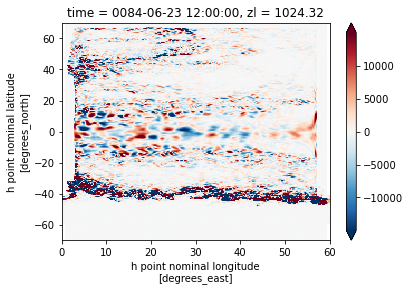

In [17]:
n_lev = 4
n_time = 10

Adhdt_load = (ds_static.area_t * dhdt).isel(time=n_time, zl=n_lev)
Adhdt_load.plot(robust=True)

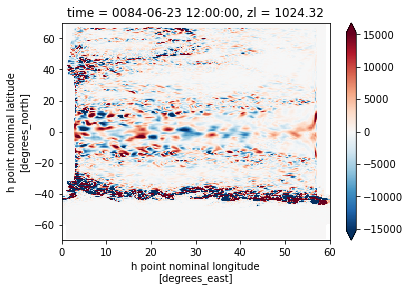

In [18]:
flux_convergence_load = flux_convergence.isel(time=n_time, zl=n_lev)
flux_convergence_load.plot(robust=True)

### (Optional) Scatter Plot of LHS vs. RHS with Datashader

Visually the budget looks good from the above plots.
But how do we know it really closes?
For this, we want to make a scatter plot of the right-hand-side of the equation vs. the left-hand-side.
But there are hundreds of thousands of points, even in this one layer.
How do we visualize them all without clogging up a scatter plot?

[Datashader](https://datashader.org/index.html) was designed to solve this problem.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
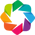

In [19]:
import holoviews as hv
from holoviews.operation.datashader import datashade
hv.extension('bokeh')

In [20]:
# convert to pandas dataframe for plotting
df = xr.merge([Adhdt_load.rename('LHS'), 
               flux_convergence_load.rename('RHS')]).to_dataframe()
df = df.reset_index()
df.head()

xh      yh                 time       zl  LHS  RHS
0  0.125 -69.875  0084-06-23 12:00:00  1024.32  NaN  NaN
1  0.125 -69.625  0084-06-23 12:00:00  1024.32  NaN  NaN
2  0.125 -69.375  0084-06-23 12:00:00  1024.32  NaN  NaN
3  0.125 -69.125  0084-06-23 12:00:00  1024.32  NaN  NaN
4  0.125 -68.875  0084-06-23 12:00:00  1024.32  NaN  NaN

In [21]:
pts = hv.Points(df, kdims=['LHS', 'RHS'])
datashade(pts).opts(width=600, height=400)

:DynamicMap   []
   :RGB   [LHS,RHS]   (R,G,B,A)

Looks good! Budget closes exactly.

## Coarsening

Once we have the budget in extensive, cell-centered form, it's trivial to coarse-grain with xarray's built-in coarsen function.

In [22]:
budget = xr.merge([(ds_static.area_t * dhdt).rename('Adhdt'), 
                   flux_convergence.rename('flux_convergence')])
budget_coarse = budget.coarsen({'xh': 8, 'yh': 8}).sum()
budget_coarse

<xarray.Dataset>
Dimensions:           (time: 100, xh: 30, yh: 70, zl: 15)
Coordinates:
  * xh                (xh) float64 1.0 3.0 5.0 7.0 9.0 ... 53.0 55.0 57.0 59.0
  * yh                (yh) float64 -69.0 -67.0 -65.0 -63.0 ... 65.0 67.0 69.0
  * time              (time) object 0084-05-03 12:00:00 ... 0085-09-18 12:00:00
  * zl                (zl) float64 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
Data variables:
    Adhdt             (yh, xh, time, zl) float64 dask.array<chunksize=(70, 30, 1, 15), meta=np.ndarray>
    flux_convergence  (time, zl, yh, xh) float32 dask.array<chunksize=(10, 15, 70, 30), meta=np.ndarray>

In [23]:
budget_coarse_load = budget_coarse.isel(time=n_time, zl=n_lev).load()

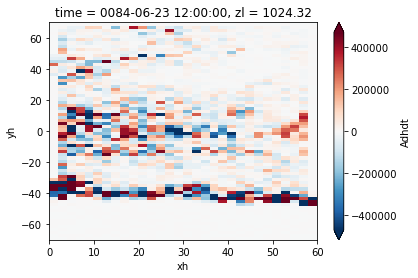

In [24]:
budget_coarse_load.Adhdt.plot(robust=True)

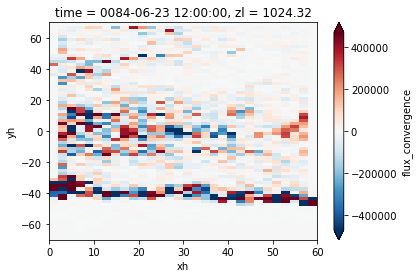

In [25]:
budget_coarse_load.flux_convergence.plot(robust=True)

Alternatively, we could coarse-grain the fluxes and take the divergence again.
For the fluxes, we want to subsample in the direction parallel to the flux and coarsen in the perpendicular direction.

In [26]:
ds.uh.dims

('time', 'zl', 'yh', 'xq')

In [27]:
factor = 8
uh_coarse = (ds.uh
               .isel(xq=slice(None, None, factor))
               .coarsen({'yh': factor})).sum()
vh_coarse = (ds.vh
               .isel(yq=slice(None, None, factor))
               .coarsen({'xh': factor})).sum()
ds_coarse = xr.merge([vh_coarse.rename('vh'),
                      uh_coarse.rename('uh')])
ds_coarse

<xarray.Dataset>
Dimensions:  (time: 100, xh: 30, xq: 31, yh: 70, yq: 71, zl: 15)
Coordinates:
  * time     (time) object 0084-05-03 12:00:00 ... 0085-09-18 12:00:00
  * xh       (xh) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 51.0 53.0 55.0 57.0 59.0
  * yq       (yq) float64 -70.0 -68.0 -66.0 -64.0 -62.0 ... 64.0 66.0 68.0 70.0
  * zl       (zl) float64 1.023e+03 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * xq       (xq) float64 0.0 2.0 4.0 6.0 8.0 10.0 ... 52.0 54.0 56.0 58.0 60.0
  * yh       (yh) float64 -69.0 -67.0 -65.0 -63.0 -61.0 ... 63.0 65.0 67.0 69.0
Data variables:
    vh       (time, zl, yq, xh) float32 dask.array<chunksize=(10, 15, 71, 30), meta=np.ndarray>
    uh       (time, zl, yh, xq) float32 dask.array<chunksize=(10, 15, 70, 31), meta=np.ndarray>

In [28]:
grid_coarse = xgcm.Grid(ds_coarse,
                        coords={'X': {'center': 'xh', 'outer': 'xq'},
                                'Y': {'center': 'yh', 'outer': 'yq'}},
                        periodic=['X'])
grid_coarse

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xh --> outer
  * outer    xq --> center
Y Axis (not periodic, boundary=None):
  * center   yh --> outer
  * outer    yq --> center

In [29]:
flux_convergence_coarse = (-grid_coarse.diff(ds_coarse.uh, 'X')
                           -grid_coarse.diff(ds_coarse.vh, 'Y', boundary='fill'))
flux_convergence_coarse

<xarray.DataArray (time: 100, zl: 15, yh: 70, xh: 30)>
dask.array<sub, shape=(100, 15, 70, 30), dtype=float32, chunksize=(10, 15, 70, 30), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0084-05-03 12:00:00 ... 0085-09-18 12:00:00
  * zl       (zl) float64 1.023e+03 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * yh       (yh) float64 -69.0 -67.0 -65.0 -63.0 -61.0 ... 63.0 65.0 67.0 69.0
  * xh       (xh) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 51.0 53.0 55.0 57.0 59.0

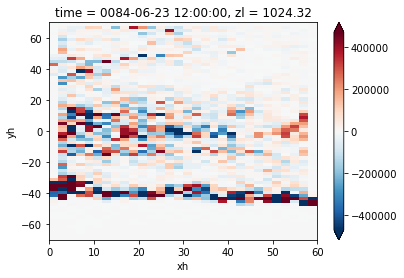

In [30]:
flux_convergence_coarse.isel(time=n_time, zl=n_lev).plot(robust=True)

This gives us the same result.